In [18]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import scienceplots  # optional, requires latex
plt.style.use(['science', 'grid'])



In [75]:
# Load solution
plate_size = 100 # mm
data_dir = "../data_fem"
data_name = f"{int(plate_size)}x{int(plate_size)}mm"
data_path = f"{data_dir}/{data_name}"

data = np.loadtxt(data_path+".dat", delimiter=" ")
X_val = data[:, :2]
u_val = data[:, 2:4]
strain_val = data[:, 4:7]
stress_val = data[:, 7:10]

solution_val = np.hstack((u_val, stress_val))

n_mesh_points = int(np.sqrt(X_val.shape[0]))

# Interpolate solution
x_grid = np.linspace(0, plate_size, n_mesh_points)
y_grid = np.linspace(0, plate_size, n_mesh_points)

def create_interpolation_fn(data_array):
    num_components = data_array.shape[1]
    interpolators = []
    for i in range(num_components):
        interp = RegularGridInterpolator(
            (x_grid, y_grid),
            data_array[:, i].reshape(n_mesh_points, n_mesh_points).T,
        )
        interpolators.append(interp)
    def interpolation_fn(x1,x2):
        return np.array([interp((x1, x2)) for interp in interpolators]).T
    return interpolation_fn

solution_fn = create_interpolation_fn(solution_val)
strain_fn   = create_interpolation_fn(strain_val)


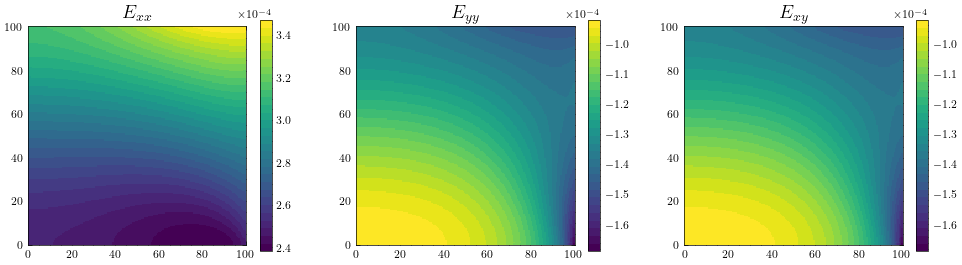

In [182]:
# Check interpolation

def pcolor_plot(AX, X, Y, C, title,colormap="copper",set_axis = 'on',colorbar=True,**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-3, 3))
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    fig.colorbar(im, ax=AX, format=formatter)
    return im

cmap = plt.get_cmap('viridis')
num_colors = 30
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = ListedColormap(color_values)

n_plot_points = 177
x_plot = np.linspace(0, plate_size, n_plot_points)
y_plot = np.linspace(0, plate_size, n_plot_points)
X, Y = np.meshgrid(x_plot, y_plot)
X_grid = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

strain_plot = strain_fn(X_grid[:, 0], X_grid[:, 1])

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X, Y, strain_plot[:,0].reshape(X.shape), r"$E_{xx}$",colormap=cmap)
im = pcolor_plot(ax[1], X, Y, strain_plot[:,1].reshape(X.shape), r"$E_{yy}$",colormap=cmap)
im = pcolor_plot(ax[2], X, Y, strain_plot[:,1].reshape(X.shape), r"$E_{xy}$",colormap=cmap)

## Strain reconstruction

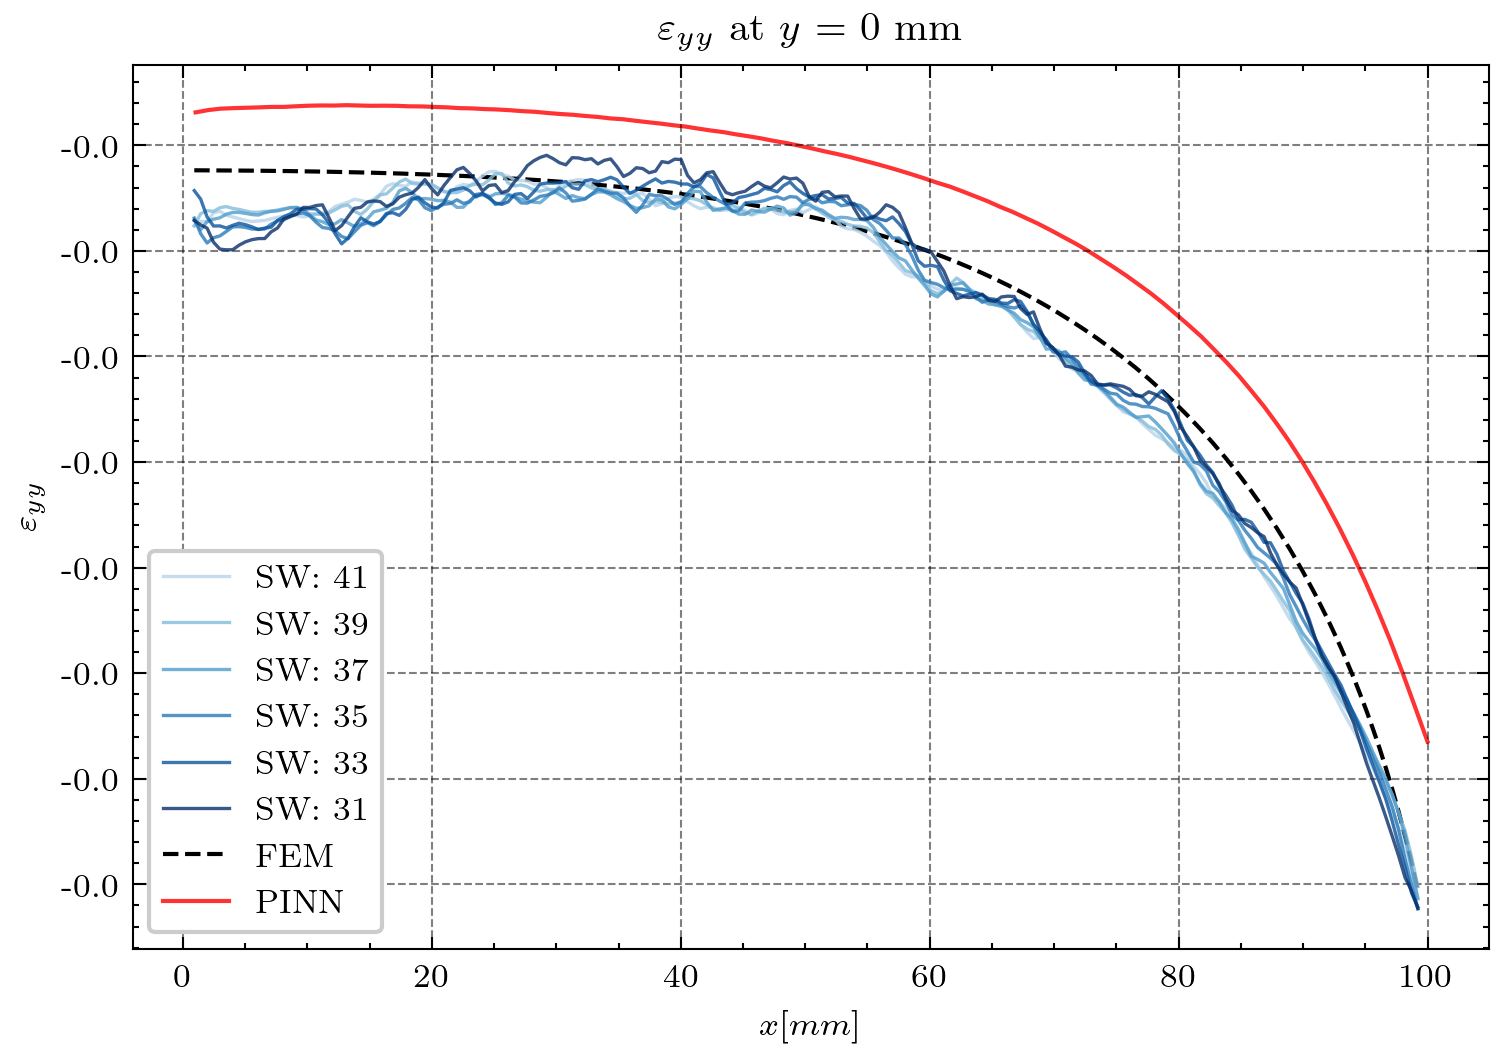

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set matplotlib font size

font_factor = 1
title_font_size = 8
axes_font_size = 8
plt.rcParams.update({
    "font.size": title_font_size*font_factor,         # Default font size for all text
    "figure.titlesize": title_font_size*font_factor, 
    "axes.labelsize": axes_font_size*font_factor,
    "xtick.labelsize": axes_font_size*font_factor,
    "ytick.labelsize": axes_font_size*font_factor,
    "legend.fontsize": axes_font_size*font_factor,
})

def plot_field_slice(ax,base_folder, field_name, y_slice, fem_ref=None):
    """
    Plots a specified field at a given relative height position.
    
    Parameters:
    - base_folder (str): Path to the folder containing the data.
    - field_name (str): Name of the field to plot (e.g., 'exy').
    - rel_height (float): Relative height position (0 to 1, where 0 is bottom and 1 is top).
    - strain_fn (function, optional): FEM function for comparison, taking x, y and returning a strain tensor.
    """
    # Load X and Y coordinates
    x_coords = pd.read_csv(os.path.join(base_folder, "x.csv"), delimiter=";").dropna(axis=1).to_numpy()
    y_coords = pd.read_csv(os.path.join(base_folder, "y.csv"), delimiter=";").dropna(axis=1).to_numpy()
    
    # Determine the index corresponding to the given relative height
    y_mid_index = np.abs(y_coords[:, 0] - y_slice).argmin()
    
    # Load the field data
    field_data = {}
    for folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            try:
                sw_value = int(folder)  # Extract SW value from folder name
                
                # Search for the corresponding field file
                for file in os.listdir(folder_path):
                    if file.startswith(field_name) and file.endswith(".csv"):
                        data_path = os.path.join(folder_path, file)
                        field_data[sw_value] = pd.read_csv(data_path, delimiter=";").dropna(axis=1).to_numpy()
            except ValueError:
                continue  # Skip non-numeric folder names
    
    # Sort by SW in descending order
    sorted_sw = sorted(field_data.keys(), reverse=True)
    
    # Prepare the figure
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(sorted_sw)))
    
    # Plot each SW
    for i, sw in enumerate(sorted_sw):
        ax.plot(x_coords[y_mid_index, :], field_data[sw][y_mid_index, :], label=f"SW: {sw}", color=colors[i], linewidth=0.8, alpha=0.8)

    # Plot FEM comparison if provided
    if fem_ref is not None:
        x_coords_mid = x_coords[y_mid_index, :]
        y_coords_mid = y_coords[y_mid_index, :]
        ax.plot(x_coords_mid, fem_ref(x_coords_mid, y_coords_mid), 'k--', label="FEM", linewidth=1,zorder=-2)
    
    ax.legend()
    # plt.show()
    return ax, x_coords, y_mid_index
field_id = 1
base_folder = "data_VSG_study/"
field_name = ["exx","eyy","exy"][field_id]
y_slice = 0
fig, ax = plt.subplots(figsize=(5, 3.5), dpi=300)
ax, x_coords, y_mid_index = plot_field_slice(ax,base_folder, field_name, y_slice, lambda x, y: strain_fn(x, y)[:, field_id])

# Plot 0 noise 
# data_path = os.path.join(base_folder, "21_0noise", field_name + ".csv")
# field_0noise = pd.read_csv(data_path, delimiter=";").dropna(axis=1).to_numpy()
# ax.plot(x_coords[y_mid_index, :], field_0noise[y_mid_index, :], label=f"SW: 21\nno noise", color='orange', linewidth=0.8, alpha=1, zorder=-1)

#Plot PINN reconstruction
noise, time, n_measurments, run_number = 1, 2, 36672, 0
results_folder, dic_prefix = "results", "dic_"
run = f"{dic_prefix}displacement_x{n_measurments}_{noise}noise_{time}min{f'-{run_number}' if run_number else ''}"
run_folder = os.path.join(results_folder, f"{noise}noise", run) + "/"

def read_data_file(filename):
    with open(filename, "r") as f:
        data = [line.split(' ', 1) for line in f]
    steps, values = zip(*[(eval(s), eval(v)) for s, v in data])
    return list(steps), list(values)

# fig = plt.figure(figsize=(5, 3.5), dpi=300)
fields = [np.array(read_data_file(os.path.join(run_folder, f"{name}_history.dat"))[1]) for name in ["Exx", "Eyy", "Exy"]]
field = np.array(fields[field_id][-1]).reshape([100, 100]).T
x_pinn = np.linspace(0, plate_size, 100)[1:]
y_pinn = np.linspace(0, plate_size, 100)
y_pinn_index = np.abs(y_pinn - y_slice).argmin()
ax.plot(x_pinn, field[y_pinn_index,1:], label="PINN", color='r', linewidth=1,alpha=0.8,zorder=-1)
ax.legend()
ax.set_xlabel(r"$x [mm]$")
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))
ax.set_ylabel([r'$\varepsilon_{xx}$',r'$\varepsilon_{yy}$',r'$\varepsilon_{xy}$'][field_id])
ax.set_title(f"{[r'$\varepsilon_{xx}$',r'$\varepsilon_{yy}$',r'$\varepsilon_{xy}$'][field_id]} at $y$ = {y_slice} mm")
plt.show()



# fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
# plot_field_slice(ax,"data_VSG_study/", "eyy", 0.0, lambda x, y: strain_fn(x, y)[:, 1])

In [169]:
y_slice = 51
y_pinn = np.linspace(0, plate_size, 100)
y_pinn_index = np.abs(y_pinn - y_slice).argmin()
print(y_pinn_index)

50


In [125]:
import pandas as pd
import numpy as np
from scipy.interpolate import RegularGridInterpolator

dic_path = r"data_dic/0noise"
dic_number = 1

X_dic = pd.read_csv(os.path.join(dic_path, "x", f"x_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
Y_dic = pd.read_csv(os.path.join(dic_path, "y", f"y_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
Ux_dic = pd.read_csv(os.path.join(dic_path, "ux", f"ux_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
Uy_dic = pd.read_csv(os.path.join(dic_path, "uy", f"uy_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
print(f"DIC data loaded, X: {X_dic.shape}, Y: {Y_dic.shape}, U: {Ux_dic.shape}, V: {Uy_dic.shape}")

dic_path = r"data_dic/1noise"
dic_number = 1

X_dic_noise = pd.read_csv(os.path.join(dic_path, "x", f"x_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
Y_dic_noise = pd.read_csv(os.path.join(dic_path, "y", f"y_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
Ux_dic_noise = pd.read_csv(os.path.join(dic_path, "ux", f"ux_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
Uy_dic_noise = pd.read_csv(os.path.join(dic_path, "uy", f"uy_{dic_number}.csv"), delimiter=";").dropna(axis=1).to_numpy()
print(f"Noisy DIC data loaded, X: {X_dic_noise.shape}, Y: {Y_dic_noise.shape}, U: {Ux_dic_noise.shape}, V: {Uy_dic_noise.shape}")

# Noise effect on coordinates
print("Noise effect on :\n X: ", np.linalg.norm(X_dic - X_dic_noise), "\n Y: ", np.linalg.norm(Y_dic - Y_dic_noise), "\n Ux: ", np.linalg.norm(Ux_dic - Ux_dic_noise), "\n Uy: ", np.linalg.norm(Uy_dic - Uy_dic_noise))
print("--> Effect on the coordinates")

U_fem = solution_fn(X_dic, Y_dic)
Ux_fem, Uy_fem = U_fem[:, :, 0].T, U_fem[:, :, 1].T

DIC data loaded, X: (191, 192), Y: (191, 192), U: (191, 192), V: (191, 192)
Noisy DIC data loaded, X: (191, 192), Y: (191, 192), U: (191, 192), V: (191, 192)
Noise effect on :
 X:  0.01732195895141329 
 Y:  0.015489574006188772 
 Ux:  0.018852004340778727 
 Uy:  0.015670433698463642
--> Effect on the coordinates


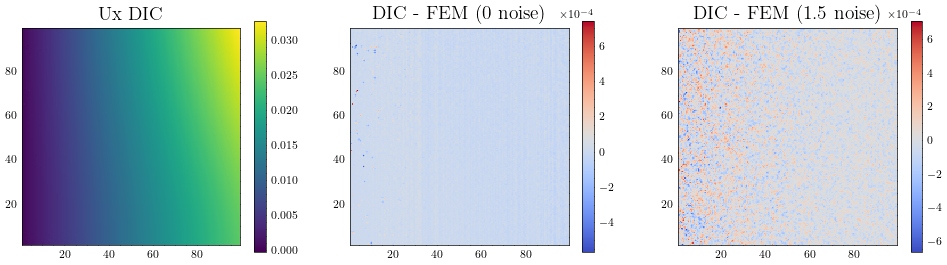

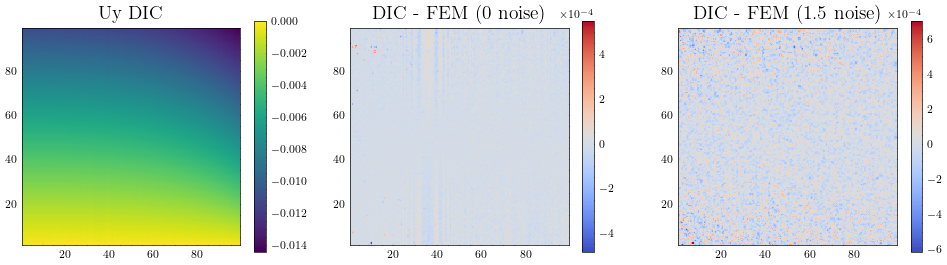

In [127]:

# # Plot DIC displacement
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X_dic, Y_dic, Ux_dic, "Ux DIC",colormap="viridis")#, cmin=0, cmax=0.015)
im = pcolor_plot(ax[1], X_dic, Y_dic, Ux_dic-Ux_fem, "DIC - FEM  (0 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)
im = pcolor_plot(ax[2], X_dic, Y_dic, Ux_dic_noise-Ux_fem.reshape(X_dic.shape), "DIC - FEM  (1.5 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], X_dic, Y_dic, Uy_dic, "Uy DIC",colormap="viridis")#, cmin=0, cmax=0.015)
im = pcolor_plot(ax[1], X_dic, Y_dic, Uy_dic-Uy_fem.reshape(X_dic.shape), "DIC - FEM  (0 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)
im = pcolor_plot(ax[2], X_dic, Y_dic, Uy_dic_noise-Uy_fem.reshape(X_dic.shape), "DIC - FEM  (1.5 noise)",colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

---- no noise ----
Coord. sigma: 1.27e-03
Grid step: 5.15e-01
Rel. grid step variation: 1.028%
---- 1.5 noise ----
Coord. sigma: 1.28e-03
Grid step: 5.15e-01
Rel. grid step variation: 1.028%


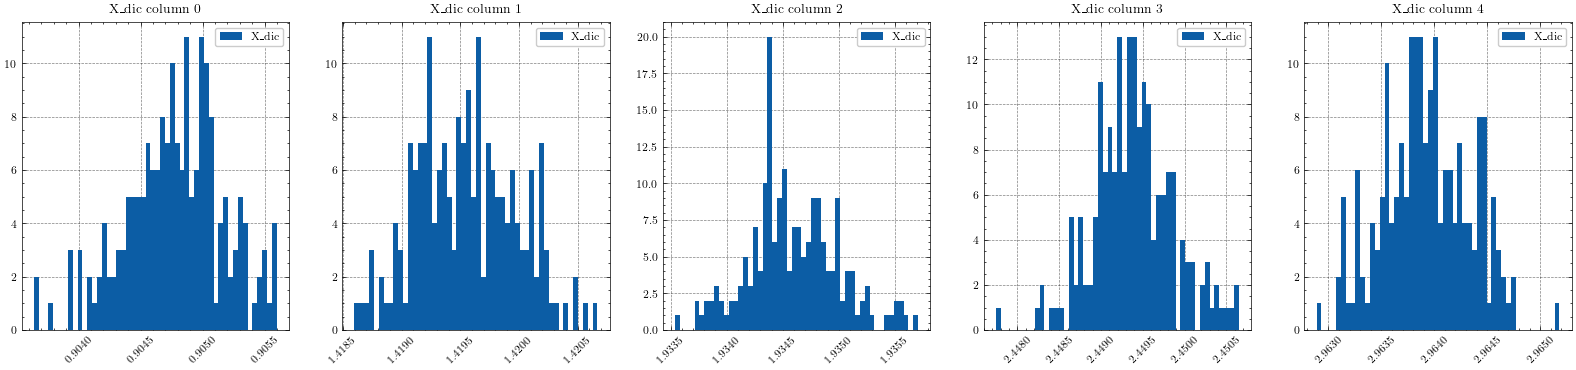

In [128]:
#Histograms of the first 5 X_dic columns
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].hist(X_dic[:,i], bins=50, label='X_dic')
    ax[i].set_title(f"X_dic column {i}")
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].legend()

print("---- no noise ----")
print(f"Coord. sigma: {np.mean(np.std(X_dic, axis=0)):0.2e}")
print(f"Grid step: {np.mean(np.diff(np.mean(X_dic, axis=0))):.2e}")
print(f"Rel. grid step variation: {np.mean(np.diff(np.mean(X_dic, axis=0)))/np.mean(np.mean(X_dic, axis=0))*100:.3f}%")

print("---- 1.5 noise ----")
print(f"Coord. sigma: {np.mean(np.std(X_dic_noise, axis=0)):0.2e}")
print(f"Grid step: {np.mean(np.diff(np.mean(X_dic_noise, axis=0))):.2e}")
print(f"Rel. grid step variation: {np.mean(np.diff(np.mean(X_dic_noise, axis=0)))/np.mean(np.mean(X_dic_noise, axis=0))*100:.3f}%")

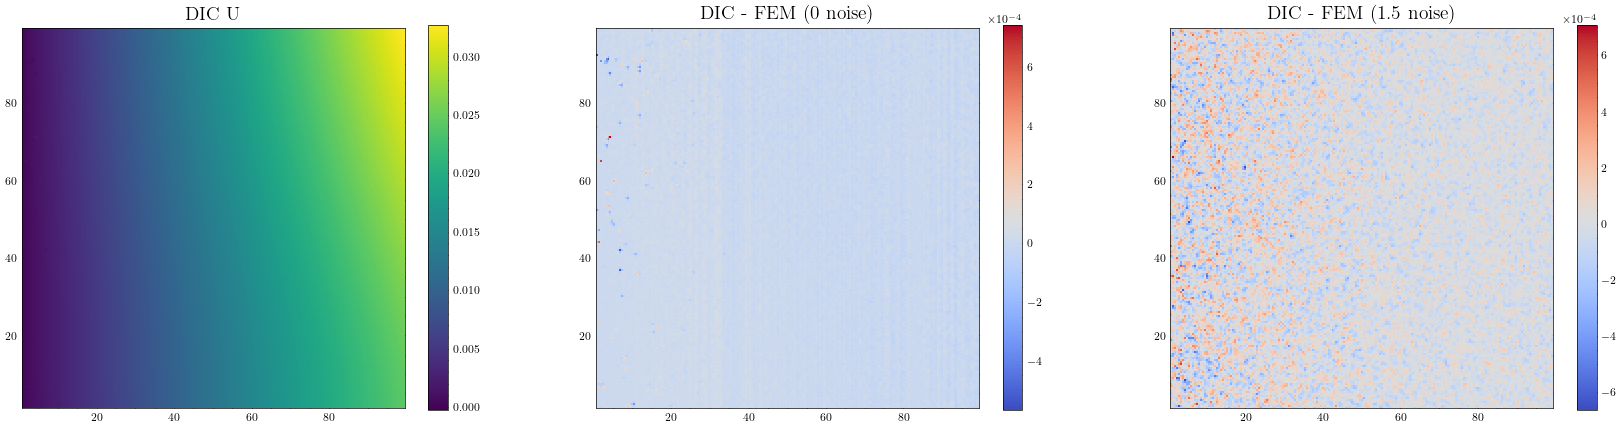

In [130]:
#extracting regular grid from DIC data

x_values = np.mean(X_dic, axis=0)
y_values = np.mean(Y_dic, axis=1)
Ux_dic_func = RegularGridInterpolator((y_values, x_values), Ux_dic, method="linear", bounds_error=False, fill_value=None)
Ux_dic_noise_func = RegularGridInterpolator((y_values, x_values), Ux_dic_noise, method="linear", bounds_error=False, fill_value=None)

X, Y = np.meshgrid(x_values, y_values)

# Interpolate DIC data to FEM grid
U_dic_interp = Ux_dic_func((Y.flatten(), X.flatten())).reshape(X.shape)
U_dic_noise_interp = Ux_dic_noise_func((Y.flatten(), X.flatten())).reshape(X.shape)



# Compute residuals (FEM - DIC)
Ux_fem = solution_fn(X.flatten(), Y.flatten())[:, 0].reshape(X.shape)

residuals =  U_dic_interp - Ux_fem
residuals_noise = U_dic_noise_interp - Ux_fem

# Plot DIC displacement
fig, ax = plt.subplots(1, 3, figsize=(21, 5))

# DIC plot
pcolor_plot(ax[0], X, Y, U_dic_interp, "DIC U", colormap="viridis")#, cmin=0, cmax=0.015)
# Residuals plot
pcolor_plot(ax[1], X, Y, residuals, "DIC - FEM  (0 noise)", colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

# Residuals plot
pcolor_plot(ax[2], X, Y, residuals_noise, "DIC - FEM  (1.5 noise)", colormap="coolwarm")#, cmin=-2e-5, cmax=2e-5)

# plt.tight_layout()
plt.show()


Alignment residual: 8.05e-05 is of order 10^-8 wich is below the noise floor


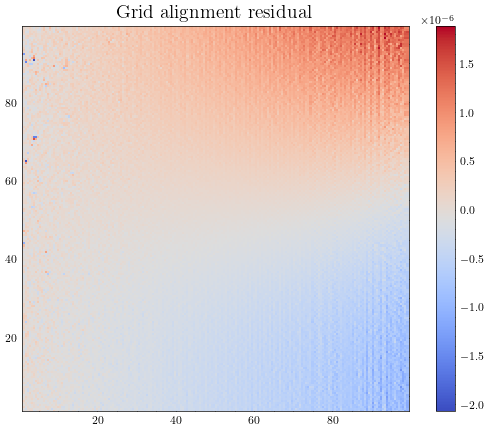

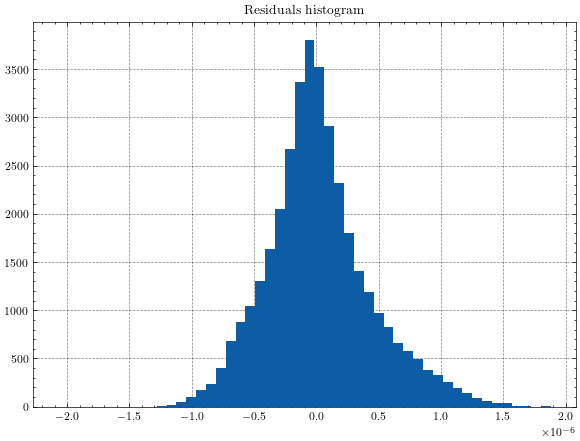

In [139]:
#alignment residual

interp_residuals = Ux_dic_func((Y_dic.flatten(), X_dic.flatten())).reshape(X_dic.shape) - Ux_dic

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
im = pcolor_plot(ax, X_dic, Y_dic, interp_residuals, "Grid alignment residual",colormap="coolwarm")
print(f"Alignment residual: {np.linalg.norm(interp_residuals):.2e} is of order 10^-8 wich is below the noise floor")

#histogram of the residuals
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(interp_residuals.flatten(), bins=50, label='residuals')
ax.set_title(f"Residuals histogram")
plt.show()